In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data=pd.read_csv('../data/external/nfl_games.csv')
datacopy=pd.read_csv('../data/external/nfl_games.csv')

In [3]:
data.shape

(16274, 12)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16274 entries, 0 to 16273
Data columns (total 12 columns):
date         16274 non-null object
season       16274 non-null int64
neutral      16274 non-null int64
playoff      16274 non-null int64
team1        16274 non-null object
team2        16274 non-null object
elo1         16274 non-null float64
elo2         16274 non-null float64
elo_prob1    16274 non-null float64
score1       16274 non-null int64
score2       16274 non-null int64
result1      16274 non-null float64
dtypes: float64(4), int64(5), object(3)
memory usage: 1.5+ MB


In [5]:
data.head()

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1
0,1920-09-26,1920,0,0,RII,STP,1503.947,1300.000,0.824651,48,0,1.0
1,1920-10-03,1920,0,0,AKR,WHE,1503.420,1300.000,0.824212,43,0,1.0
2,1920-10-03,1920,0,0,RCH,ABU,1503.420,1300.000,0.824212,10,0,1.0
3,1920-10-03,1920,0,0,DAY,COL,1493.002,1504.908,0.575819,14,0,1.0
4,1920-10-03,1920,0,0,RII,MUN,1516.108,1478.004,0.644171,45,0,1.0


### Determining which team has won

In [6]:
Team1board = []
Team2board = []
for index, row in data.iterrows():
    if row.score1>row.score2:
        Team1board.append(1)
        Team2board.append(0)
    else:
        Team1board.append(0)
        Team2board.append(1) 


In [7]:
data['Team1board'] = pd.DataFrame(Team1board, index =data.index)
data.tail()
data['Team2board'] = pd.DataFrame(Team2board, index =data.index)
data.head()

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1,Team1board,Team2board
0,1920-09-26,1920,0,0,RII,STP,1503.947,1300.000,0.824651,48,0,1.0,1,0
1,1920-10-03,1920,0,0,AKR,WHE,1503.420,1300.000,0.824212,43,0,1.0,1,0
2,1920-10-03,1920,0,0,RCH,ABU,1503.420,1300.000,0.824212,10,0,1.0,1,0
3,1920-10-03,1920,0,0,DAY,COL,1493.002,1504.908,0.575819,14,0,1.0,1,0
4,1920-10-03,1920,0,0,RII,MUN,1516.108,1478.004,0.644171,45,0,1.0,1,0


### Calculating The win count of each team

In [8]:
#wincounts for team 1
WinCounts1 = data.groupby(['team1'])['Team1board'].sum().reset_index()
WinCounts1 = WinCounts1.rename(columns={'team1': 'team'})


In [9]:
#wincounts for team 2
WinCounts2 = data.groupby(['team2'])['Team2board'].sum().reset_index()
WinCounts2 = WinCounts2.rename(columns={'team2': 'team'})

In [10]:
#Merging the wincounts dataframes
Wincounts=pd.merge(WinCounts1,WinCounts2,how='outer',on=['team'])
Wincounts=Wincounts.fillna(0)
Wincounts.Team1board = Wincounts.Team1board.astype(int)
Wincounts.Team2board = Wincounts.Team2board.astype(int)
Wincounts.isnull().any()


team          False
Team1board    False
Team2board    False
dtype: bool

In [11]:
#Calculating the total wincounts of each team
Wincounts['Totalwins'] = Wincounts['Team1board'] + Wincounts['Team2board'] 
Wincounts=Wincounts.sort_values(['Totalwins'], ascending=[False]).reset_index()
Wincounts.head()

,index,team,Team1board,Team2board,Totalwins
0,15,CHI,455,341,796
1,42,GB,452,343,795
2,69,NYG,406,327,733
3,75,PIT,389,282,671
4,99,WSH,361,279,640


In [12]:
data1 = pd.DataFrame(Wincounts, columns=['team', 'Totalwins'])
data2=data1.rename(columns={'team': 'team1'})
data3=data1.rename(columns={'team': 'team2'})

### No of games played by each team

In [13]:
PlayCounts1 = data.groupby(['team1'])['Team1board'].count().reset_index()
PlayCounts1 = PlayCounts1.rename(columns={'team1': 'team'})

In [14]:
PlayCounts2 = data.groupby(['team2'])['Team2board'].count().reset_index()
PlayCounts2 = PlayCounts2.rename(columns={'team2': 'team'})

In [15]:
PlayCounts=pd.merge(PlayCounts1,PlayCounts2,how='outer',on=['team'])
PlayCounts=PlayCounts.fillna(0)
PlayCounts.Team1board = PlayCounts.Team1board.astype(int)
PlayCounts.Team2board = PlayCounts.Team2board.astype(int)
PlayCounts.isnull().any()

team          False
Team1board    False
Team2board    False
dtype: bool

In [16]:
PlayCounts['Totalplays'] = PlayCounts['Team1board'] + PlayCounts['Team2board'] 
PlayCounts=PlayCounts.sort_values(['Totalplays'], ascending=[False]).reset_index()

In [17]:
PlayCounts['team'].nunique()
dataplay = pd.DataFrame(PlayCounts, columns=['team', 'Totalplays'])
dataplay.head()

,team,Totalplays
0,CHI,1422
1,GB,1408
2,NYG,1370
3,ARI,1352
4,DET,1269


### Calculating the win rate of each team

In [18]:
#merging wincounts and play counts
Finaldata=pd.merge(data1,dataplay,how='outer',on=['team'])
Finaldata=Finaldata.fillna(0)
Finaldata.head()

,team,Totalwins,Totalplays
0,CHI,796,1422
1,GB,795,1408
2,NYG,733,1370
3,PIT,671,1249
4,WSH,640,1260


In [19]:
# Finding the winrate of each team
Finaldata['winrate'] = Finaldata['Totalwins']/Finaldata['Totalplays']
Finaldata = pd.DataFrame(Finaldata, columns=['team', 'winrate'])
Finaldata['team']=Finaldata['team']
Finaldata1=Finaldata.rename(columns={'team': 'team1'})
Finaldata2=Finaldata.rename(columns={'team': 'team2'})

Finaldata.head()

,team,winrate
0,CHI,0.559775
1,GB,0.564631
2,NYG,0.535036
3,PIT,0.537230
4,WSH,0.507937


In [20]:
Finaldata.dtypes

team        object
winrate    float64
dtype: object

### Team vs winrate Plot

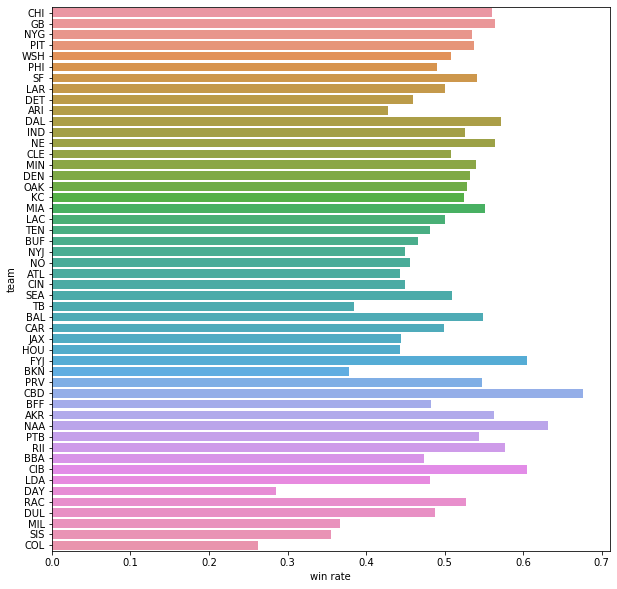

In [21]:
plt.figure(figsize=(10,10))
ax = sns.barplot(x='winrate',y='team',data=Finaldata.head(50))
ax.set(xlabel='win rate', ylabel='team')
plt.show()

## Calculating the average scores, elo ratings and probabilities of each team as each team played with other team several times not just once.

In [22]:
teams = set(datacopy.team2.values)
teams.update(list(datacopy.team1.values))
len(teams)

123

In [23]:
avg_data = pd.DataFrame(columns = [ 'team1', 'team2', 'elo1', 'elo2', 'score1', 'score2', 'elo_prob1'])

isdone = set()

def getDict(input_data, output_data):
    temp = dict()
    temp['team1'] = input_data.iloc[0,4]
    temp['team2'] = input_data.iloc[0,5]
    temp['elo1'] = input_data.elo1.mean()
    temp['elo2'] = input_data.elo2.mean()
    temp['score1'] = input_data.score1.mean()
    temp['score2'] = input_data.score2.mean()
    temp['elo_prob1'] = input_data.elo_prob1.mean()
    return temp

avg_data_list = list()
for A in teams:
    for B in teams:
        if( A == B):
            continue
        if(not( A+B in isdone)):
            isdone.add(A+B)
            isdone.add(B+A)
            filter1 = (data.team1 == A) & (data.team2 == B)
            filter2 = (data.team1 == B) & (data.team2 == A)
            filtered_data = data.where(filter1 | filter2).dropna()
            if( len(filtered_data.index) > 0):
                avg_data_list.append(getDict(filtered_data, avg_data))


avg_data = avg_data.append(avg_data_list)

In [24]:
avg_data.dtypes


team1         object
team2         object
elo1         float64
elo2         float64
score1       float64
score2       float64
elo_prob1    float64
dtype: object

In [25]:
#Converting the float score in to int
avg_data.score1=avg_data.score1.astype(int)
avg_data.score2=avg_data.score2.astype(int)

In [26]:
avg_data.to_csv('avg_data', index=False, encoding='utf-8')

In [27]:
#merging the winrate with avg_data
avg_data=pd.merge(avg_data,Finaldata1,on='team1')
avg_data.head()

,team1,team2,elo1,elo2,score1,score2,elo_prob1,winrate
0,GB,NYA,1611.0635,1405.1520,6,0,0.824846,0.564631
1,GB,COL,1416.8870,1340.6940,3,0,0.692700,0.564631
2,GB,DPN,1513.6175,1537.6645,10,3,0.556308,0.564631
3,GB,RCH,1604.0510,1362.6680,33,13,0.853670,0.564631
4,GB,CIB,1577.6000,1362.9190,12,7,0.833408,0.564631


In [28]:
avg_data=pd.merge(avg_data,Finaldata2,on='team2')
avg_data.head()

,team1,team2,elo1,elo2,score1,score2,elo_prob1,winrate_x,winrate_y
0,GB,NYA,1611.063500,1405.152000,6,0,0.824846,0.564631,0.413793
1,BFF,NYA,1434.045000,1410.299000,8,19,0.625009,0.483146,0.413793
2,CIB,NYA,1419.376333,1436.644667,13,14,0.567733,0.604651,0.413793
3,NYG,NYA,1539.756400,1463.776800,10,7,0.659389,0.535036,0.413793
4,PRV,NYA,1465.321750,1485.717500,10,8,0.561610,0.547619,0.413793


### Label Encoding the categorical columns

In [29]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
avg_data['team1'] = le.fit_transform(avg_data['team1'])
avg_data['team2'] = le.fit_transform(avg_data['team2'])
avg_data.head()

,team1,team2,elo1,elo2,score1,score2,elo_prob1,winrate_x,winrate_y
0,42,73,1611.063500,1405.152000,6,0,0.824846,0.564631,0.413793
1,7,73,1434.045000,1410.299000,8,19,0.625009,0.483146,0.413793
2,18,73,1419.376333,1436.644667,13,14,0.567733,0.604651,0.413793
3,67,73,1539.756400,1463.776800,10,7,0.659389,0.535036,0.413793
4,74,73,1465.321750,1485.717500,10,8,0.561610,0.547619,0.413793


### plot for elo1, elo2 and score

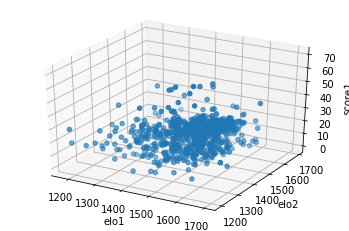

In [30]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(avg_data['elo1'], avg_data['elo2'], avg_data['score1'])
threedee.set_xlabel('elo1')
threedee.set_ylabel('elo2')
threedee.set_zlabel('score1')
plt.show()

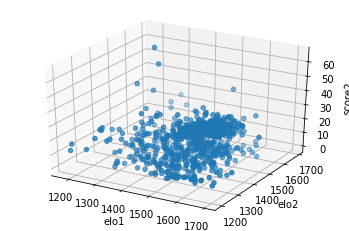

In [31]:
threedee1 = plt.figure().gca(projection='3d')
threedee1.scatter(avg_data['elo1'], avg_data['elo2'], avg_data['score2'])
threedee1.set_xlabel('elo1')
threedee1.set_ylabel('elo2')
threedee1.set_zlabel('score2')
plt.show()

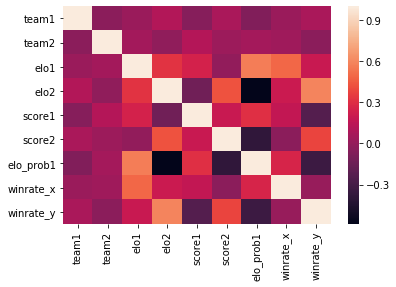

In [32]:
#Finding the correlation between all the columns
corr = avg_data.corr()
sns.heatmap(corr)

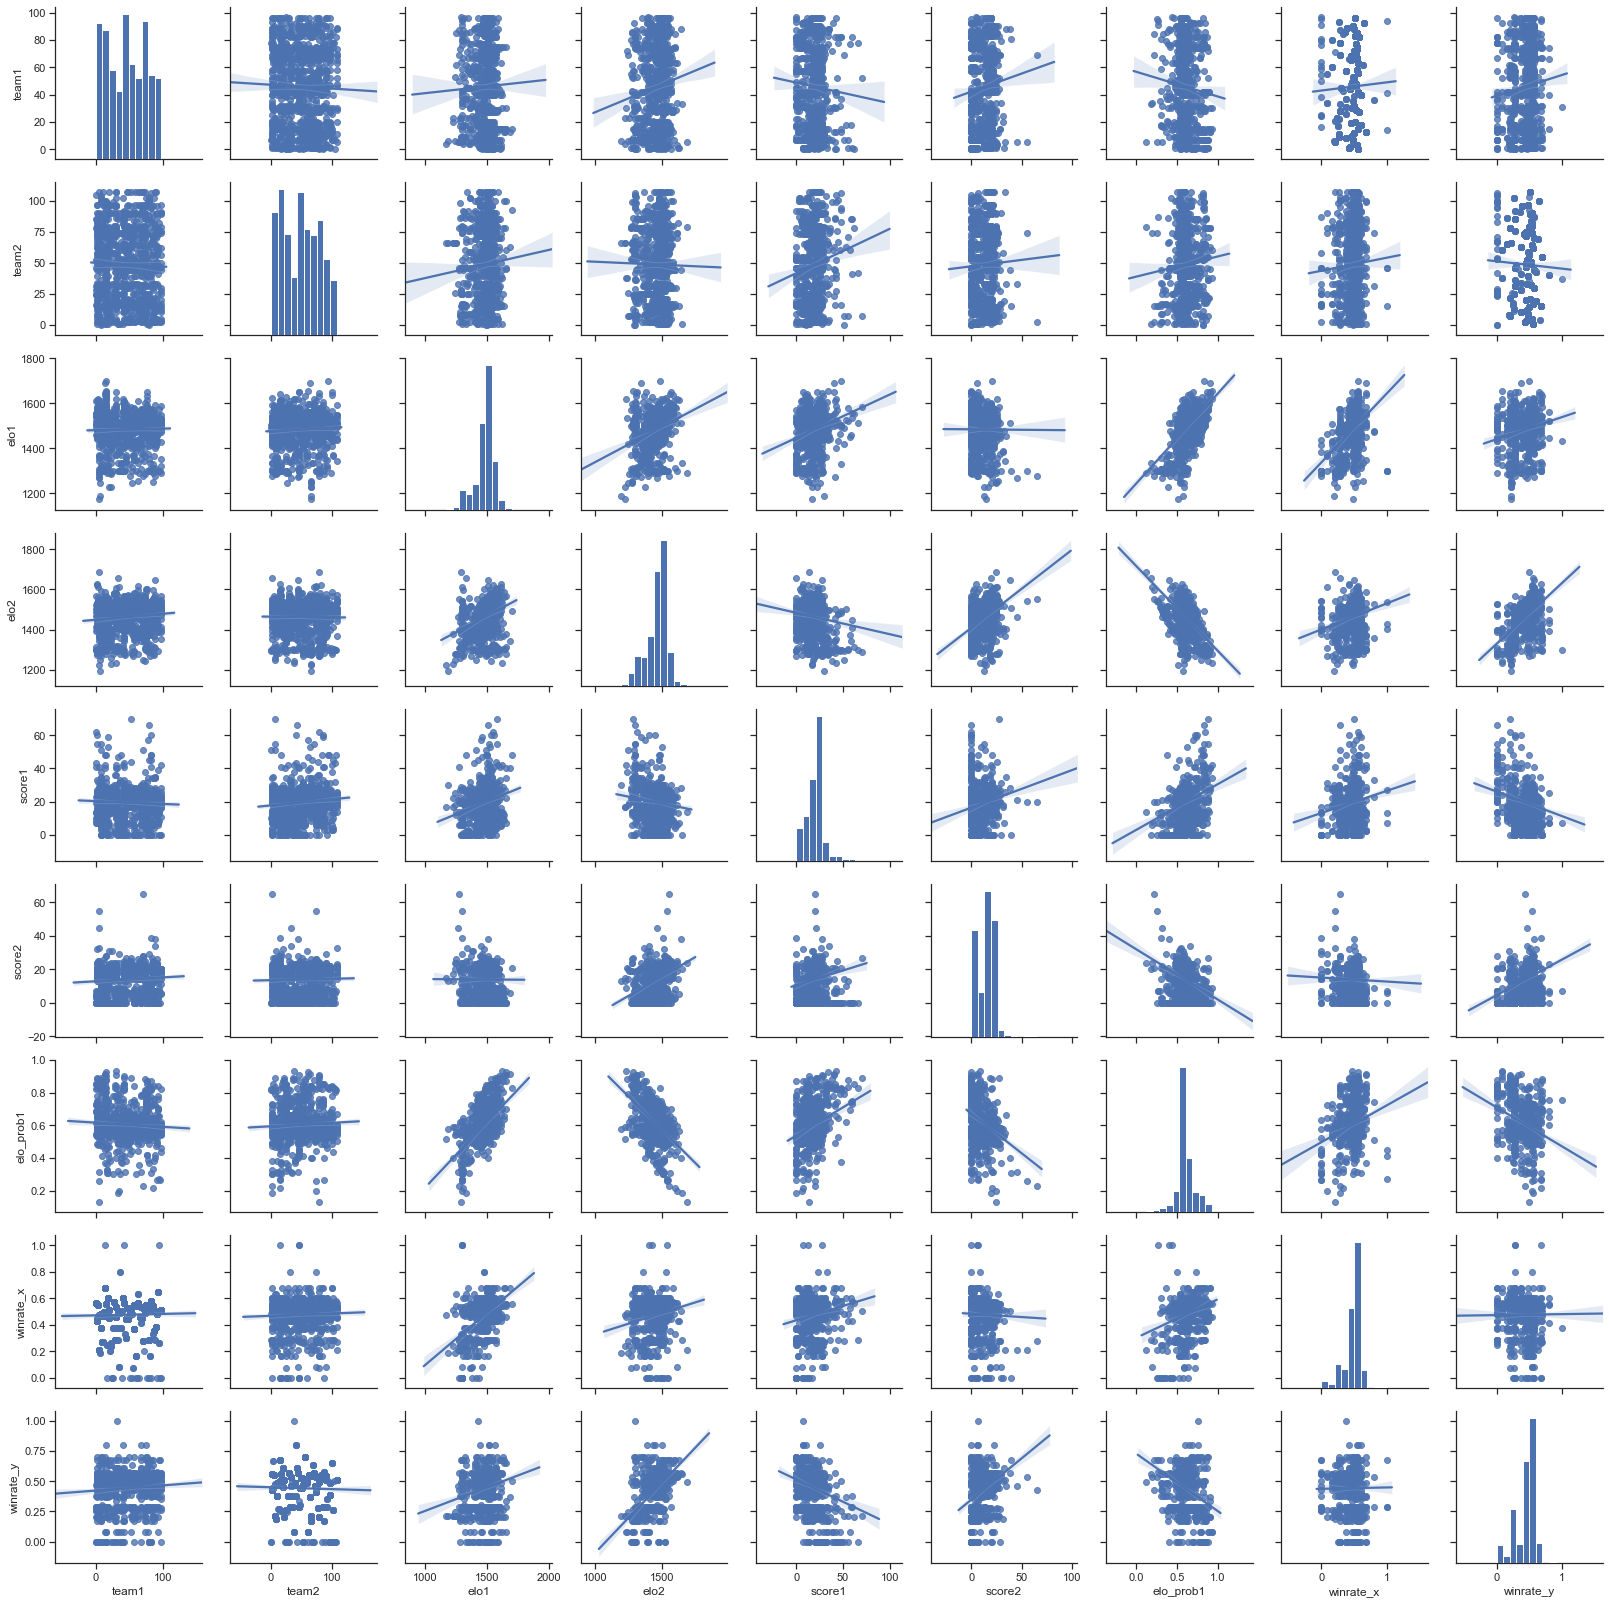

In [33]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(avg_data, kind="reg")

In [34]:
#Making the dependent and independent variables
X1=avg_data.drop(columns=['score1'])
X2=avg_data.drop(columns=['score2'])
Y1 = pd.DataFrame(avg_data, columns = ['score1'])
Y2 = pd.DataFrame(avg_data, columns = ['score2'])

### Splitting the data into training and test set

In [35]:
from sklearn.model_selection import train_test_split

xtrain1, xtest1, ytrain1, ytest1 = train_test_split(X1, Y1, test_size=0.2)
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(X2, Y2, test_size=0.2)



### Linear Regression

In [36]:
#Fitting the first training set
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(xtrain1,ytrain1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
# Finding the regression coefficient
regr.coef_

array([[-1.03956407e-02,  2.05527897e-02,  4.80006662e-02,
        -3.49845239e-02,  4.56295397e-01, -1.02485624e+00,
         4.46811787e+00, -1.92230203e+01]])

In [38]:
# Finding the regression line intercept
regr.intercept_

array([-0.16304089])

In [39]:
#Rounding of to integer
y1prediction1=np.round(regr.predict(xtest1))


In [40]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f"
      % mean_squared_error(ytest1, y1prediction1))

Mean squared error: 69.96


In [41]:
print('Variance score: %.2f' % r2_score(ytest1, y1prediction1))

Variance score: 0.26


In [42]:
regr.score(xtest1,ytest1)

0.270880390768814

### Confusion matrix for true vs predicted values

In [43]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest1,y1prediction1)

Text(0.5, 156.5, 'truth')

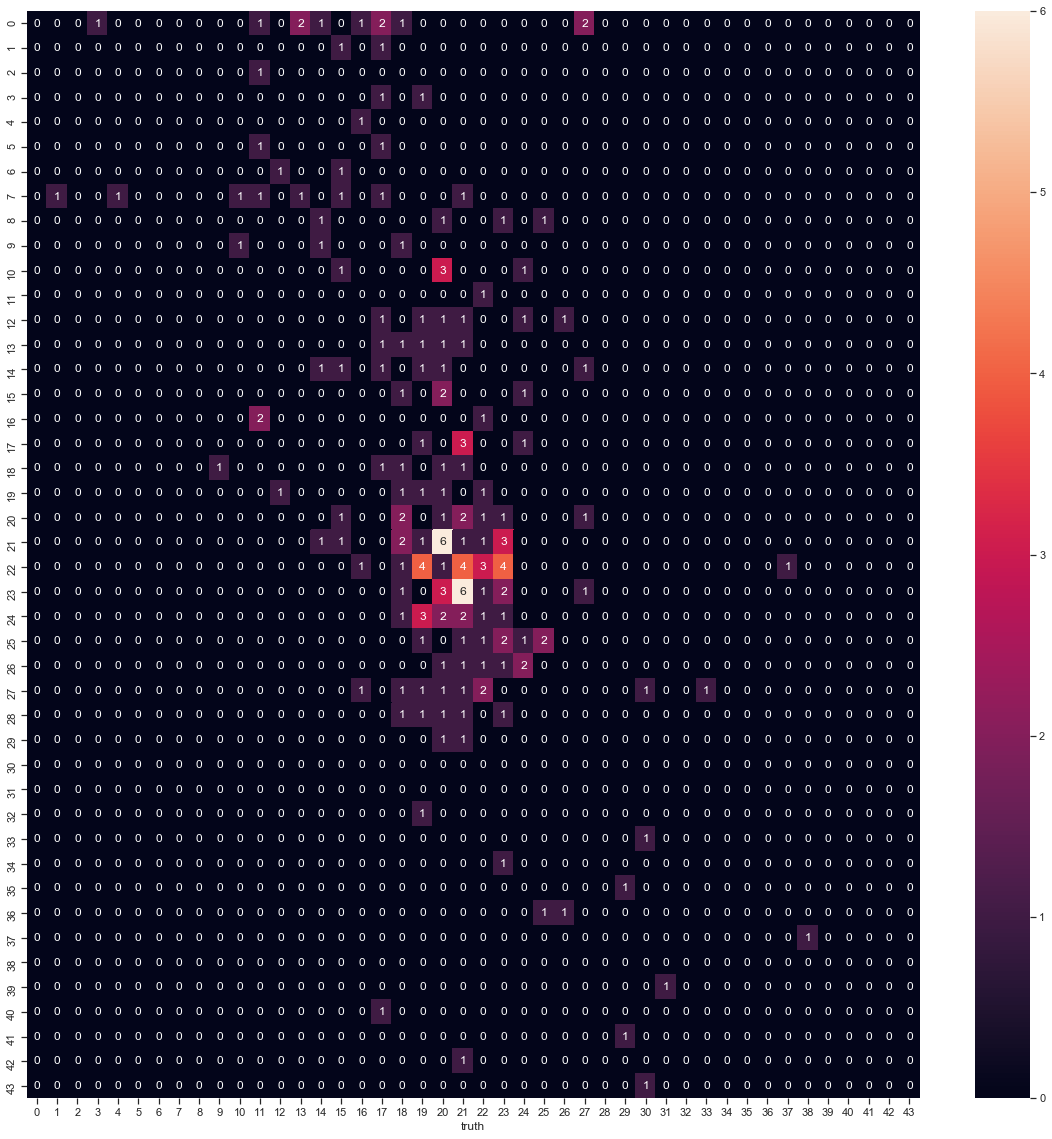

In [44]:
plt.figure(figsize=(20,20))
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.xlabel('truth')

In [45]:
#Fitting the first training set
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(xtrain2,ytrain2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [46]:
# Finding the regression coefficient
regr.coef_

array([[ 1.49039136e-02, -4.41859455e-04,  3.17076957e-02,
        -1.75272416e-02,  3.68285618e-01, -5.35318595e+01,
        -2.79575472e+00,  1.50721768e+01]])

In [47]:
# Finding the regression line intercept
regr.intercept_

array([11.5744472])

In [48]:
#Rounding of to integer
y2prediction2=np.round(regr.predict(xtest2))

In [49]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f"
      % mean_squared_error(ytest2, y2prediction2))

Mean squared error: 44.01


In [50]:
print('Variance score: %.2f' % r2_score(ytest2, y2prediction2))

Variance score: 0.27


In [51]:
regr.score(xtest1,ytest1)

-1.1484562627299812

### Regression using Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2,
                        random_state=10, shuffle=False)
regr = RandomForestRegressor(max_depth=50, random_state=0,
                              n_estimators=40)
regr.fit(xtrain1, ytrain1.values.ravel()) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [53]:
ypredictionforest=np.round(regr.predict(xtest1))


In [54]:
regr.score(xtest1,ytest1)

0.3342027409129771

### Confusion matrix for the Truth vs predicted values

In [55]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest1,ypredictionforest)

Text(0.5, 156.5, 'truth')

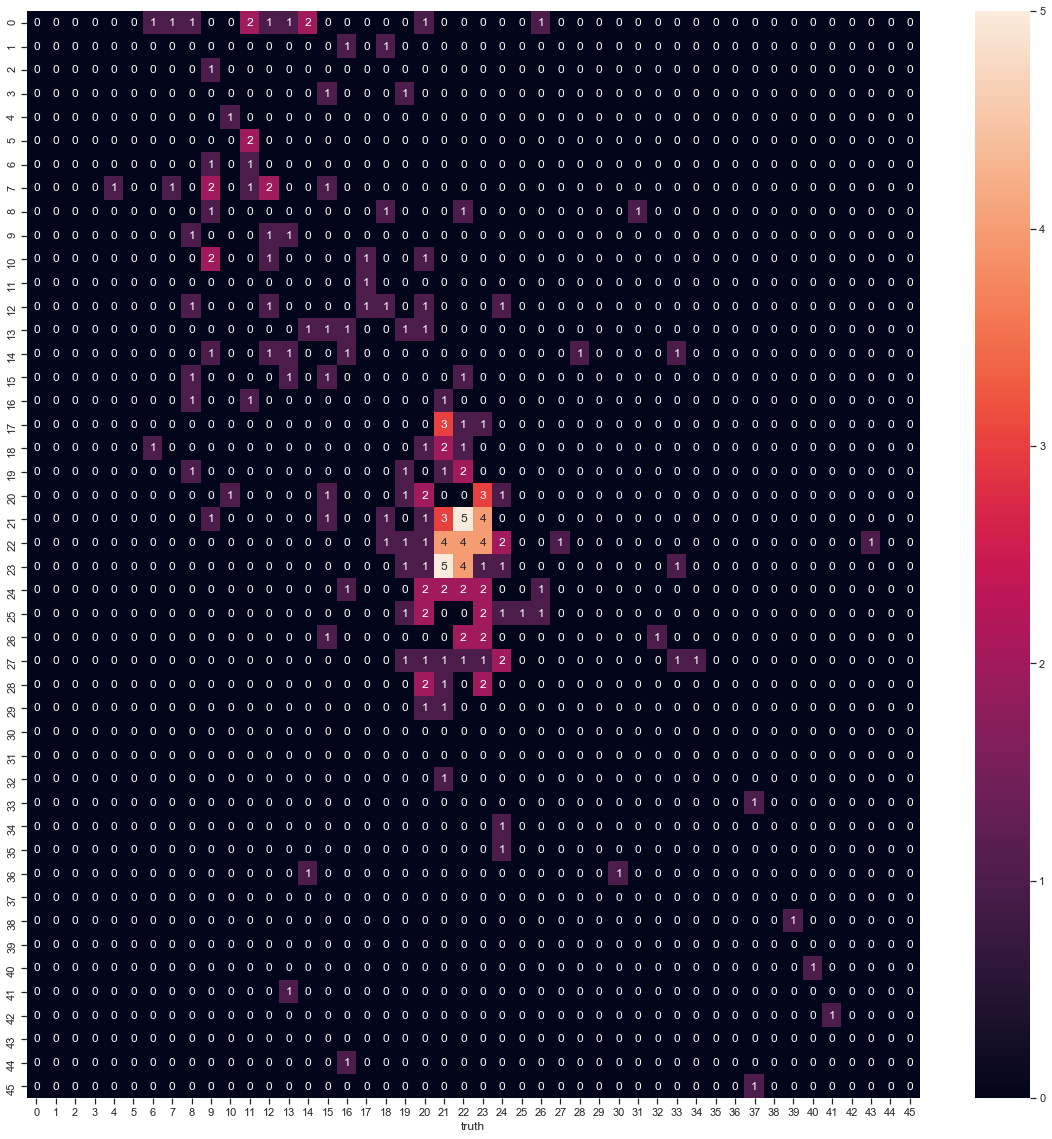

In [56]:
plt.figure(figsize=(20,20))
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.xlabel('truth')

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2,
                        random_state=10, shuffle=False)
regr = RandomForestRegressor(max_depth=50, random_state=0,
                              n_estimators=40)
regr.fit(xtrain2, ytrain2.values.ravel()) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [58]:
ypredictionforest=np.round(regr.predict(xtest2))

In [59]:
regr.score(xtest2,ytest2)

0.6353426219711431

### Results

 #### The acccuracy is more with the Random forest model when compared to linear regression while calculating for both Scores 1 and 2